Python2. Кейс для самостоятельного решения

In [40]:
#Импорт библиотек
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
import plotly.express as px
from sklearn.metrics import mean_squared_error, r2_score


Изучаем исторические данные. Определяем, есть ли выбросы и нулевые значения.

In [46]:
#Загрузка датафрейма
df=pd.read_csv('Данные для финального кейса - Исторические данные.csv')
display(df)

,dates,Revenue
0,2020-01-01,263.548353
1,2020-01-02,339.025061
2,2020-01-03,308.022741
3,2020-01-04,329.983017
4,2020-01-05,363.065365
...,...,...
1091,2022-12-27,1494.658147
1092,2022-12-28,1568.942676
1093,2022-12-29,1569.861364
1094,2022-12-30,1598.670921


In [47]:
#Проверка датафрейма на нулевые значения
null_values = df.isnull().sum()
print(null_values)

dates      0
Revenue    0
dtype: int64


Нулевых значений не выявлено

Определяем, есть ли выбросы.

In [48]:
# Преобразуем столбец dates в datetime, то есть указываем явным образом, что это даты
df['dates'] = pd.to_datetime(df['dates'])

# Применяем тест Дики-Фуллера
result = adfuller(df['Revenue'])

# Интерпретируем результаты
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


if result[1] < 0.05:
    print("Отклоняем гипотезу о наличии единичного корня (ряд стационарен)")
else:
    print("Не удается отклонить гипотезу о наличии единичного корня (ряд не стационарен)")
    # Построение графика


ADF Statistic: -1.239341
p-value: 0.656447
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Не удается отклонить гипотезу о наличии единичного корня (ряд не стационарен)


Поскольку p-value (0.656447) больше 0.05 и ADF статистика (-1.239341) больше всех критических значений,  нельзя отвергнуть нулевую гипотезу. Это говорит о том, что  временной ряд не стационарен.


Строим график «Зависимость Revenue от Dates» с помощью библиотеки Plotly.Express.

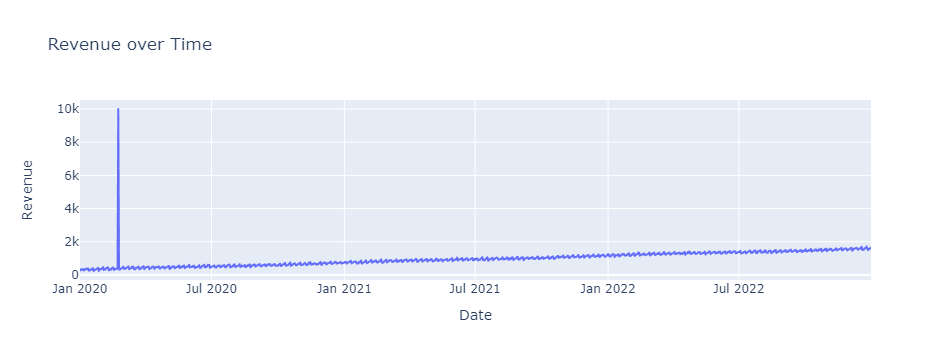

In [49]:
fig = px.line(df, x='dates', y='Revenue', title='Revenue over Time', labels={'Revenue': 'Revenue', 'dates': 'Date'})
fig.show()


На графике отчетливо виден выброс 23 февраля 2020 года.

Чистим датафрейм от выбросов с помощью квартилей

In [50]:
#Чистка от выбросов с помощью квартилей
q1, q3 =np.percentile(df['Revenue'],[25,75])
iqr=q3-q1
lower_threshold=q1-1.3*iqr
upper_threshold=q3+1.3*iqr
print(f"Нижний порог: {lower_threshold}")
print(f"Верхний порог: {upper_threshold}")

# Вычисляем скользящее среднее с окном 7
df['rolling_mean'] = df['Revenue'].rolling(window=7, min_periods=1, center=False).mean()

# Используем np.where для создания нового столбца с обработанными квартилями
# Создаем столбец processed_quartilies
df['processed_quartiles'] = np.where(
    (df['Revenue'] < lower_threshold) | (df['Revenue'] > upper_threshold),
    df['rolling_mean'].shift(1),
    df['Revenue']
)

# Удаляем временный столбец rolling_mean
df.drop(columns=['rolling_mean'], inplace=True)

# Выводим результирующий DataFrame
print(df)         

Нижний порог: -263.25871288750034
Верхний порог: 2164.5600007625003
          dates      Revenue  processed_quartiles
0    2020-01-01   263.548353           263.548353
1    2020-01-02   339.025061           339.025061
2    2020-01-03   308.022741           308.022741
3    2020-01-04   329.983017           329.983017
4    2020-01-05   363.065365           363.065365
...         ...          ...                  ...
1091 2022-12-27  1494.658147          1494.658147
1092 2022-12-28  1568.942676          1568.942676
1093 2022-12-29  1569.861364          1569.861364
1094 2022-12-30  1598.670921          1598.670921
1095 2022-12-31  1642.217711          1642.217711

[1096 rows x 3 columns]


Снова строим график зависимости Revenue от dates, добавляя ощищенный от выбросов столбец processed_quartiles

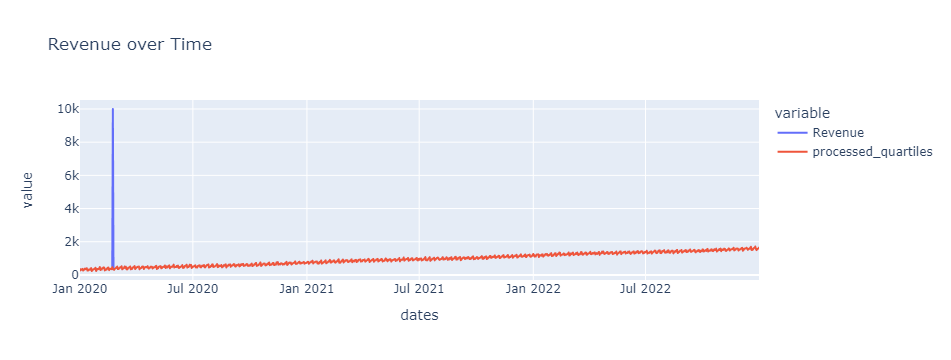

In [51]:
fig = px.line(df, x='dates', y=['Revenue', 'processed_quartiles'], title='Revenue over Time')
fig.show()


Наблюдается восходящий тренд. Если отключить на графике отрисовку Revenue, можем видеть недельную сезонность.

Вычислим среднее Revenue за 2022 год и отдельно за декабрь 2022 года

In [52]:
#Создаем новый DataFrame df_2022, в который помещаются только те строки из исходного DataFrame, где значение в столбце 
#dates больше или равно 1 января 2022 года
df_2022=df[df['dates']>='2022-01-01']

#Рассчитываем среднюю величину для 2022 года по столбцу processed_quartiles
avg_2022=df_2022['processed_quartiles'].mean()
print(f"Среднее значение Revenue за 2022 год: {avg_2022}")

#Создаем новый датафрейм, куда попадают данные только за декабрь 2022 года
dec_2022_df=df[df['dates']>='2022-12-01']
avg_dec_2022=dec_2022_df['processed_quartiles'].mean()
print(f"Среднее значение Revenue за декабрь 2022 года: {avg_dec_2022}")


Среднее значение Revenue за 2022 год: 1378.1355727835617
Среднее значение Revenue за декабрь 2022 года: 1579.2193224516127


Мы видим, что среднее значение в декабре 2022 года выше, чем среднее значение в целом по 2022 году.
Это объясняется восходящим трендом.

Проверка ряда на стационарность с помощью теста Дики-Фуллера

In [53]:
ser=df['processed_quartiles']
result = adfuller(ser)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -0.0007464977607645531
p-value: 0.9584703076614842


Здесь p-value выше 0.05, следовательно, временной ряд не стационарен.

Если ряд не стационарен, лучше всего использовать Prophet. В отличие от Arima и Sarima, он не требует предварительной обработки данных.

Построение проверочного прогноза для выявления точности модели

In [54]:
#Здесь столбец 'dates' переименовывается в 'ds', а 'processed_quartiles' — в 'y'. 
#Это необходимо, поскольку Prophet ожидает, что дата будет находиться в столбце с названием 'ds', а значение, 
#которое нужно предсказать — в столбце с названием 'y'
df=df.rename(columns={'dates':'ds','processed_quartiles':'y'})

#Разделение данных на обучающую и тестовую выборки:
#df.shape[0] возвращает общее число строк в df.
#index вычисляет количество строк, которое составит 30% от общего числа данных.
#Затем данные делятся на две части:
#train — обучающая выборка (все строки, кроме последних 30%),
#test — тестовая выборка (последние 30% строк).
index=int(df.shape[0]*0.3)
train,test=df[:-index],df[-index:]

#Обучение модели:
#Создается экземпляр модели Prophet.
#Модель обучается на обучающей выборке train с помощью метода fit
model=Prophet()
model.fit(train)

#Создание датафрейма для будущих прогнозов
#Создаем датафрейм, который содержит даты на будущее, равные количеству строк index 
#Этот датафрейм будет использоваться для прогнозирования
#После этого выбираются только последние index строк (это даты, для которых будет выполнено прогнозирование)
predictions_period=model.make_future_dataframe(periods=index)
predictions_period=predictions_period[-index:]

#Выполняем прогнозирование на основе будущих дат.
#Результаты прогноза сохраняются в int_forecast, где выбираются только столбцы ds (даты), yhat (прогнозируемые значения), 
#yhat_lower (нижняя граница прогнозируемого значения) и yhat_upper (верхняя граница прогнозируемого значения)
int_forecast=model.predict(predictions_period)
int_forecast=int_forecast[['ds','yhat','yhat_lower','yhat_upper']]

#Импортируем функцию r2_score из библиотеки sklearn.metrics для оценки качества прогноза
from sklearn.metrics import r2_score

#Ыычисляем коэффициент детерминации R2, который показывает, насколько хорошо модель объясняет вариацию в данных
r2=r2_score(test['y'], int_forecast['yhat'])

print("R2=",r2)

12:29:00 - cmdstanpy - INFO - Chain [1] start processing
12:29:00 - cmdstanpy - INFO - Chain [1] done processing


R2= 0.9563016145859166


Модели с показателем R2>0.7 считаются хорошими, а больше 0.9 - отличными, поэтому наша модель отличная.

Построение прогноза на период акции

In [ ]:
model=Prophet()
model.fit(df)

#Создание будущего датафрейма для прогнозирования
#Создаем новый датафрейм, который содержит даты на будущее для прогнозирования.
#В данном случае добавляем 92 дня в будущее
#Этот датафрейм будет содержать как даты из первоначального набора данных, так и новые (будущие) даты.
predictions_period=model.make_future_dataframe(periods=92)

#Выполняем прогноз на основе ранее созданного датафрейма predictions_period.
#Здесь происходит расчет прогнозируемых значений временного ряда на указанные даты.
#Результат сохраняется в переменной forecast, которая будет содержать столбцы с прогнозируемыми значениями
#и другими важными метриками (например, нижними и верхними границами прогноза)
forecast=model.predict(predictions_period)
forecast=forecast[['ds','yhat','yhat_lower','yhat_upper']]

#Фильтруем forecast, оставляя только те строки, где значение в столбце ds (дата) больше или равно 2023-01-01
forecast=forecast[forecast['ds']>='2023-01-01']


12:29:05 - cmdstanpy - INFO - Chain [1] start processing
12:29:05 - cmdstanpy - INFO - Chain [1] done processing


Для построения прогноза на период промо в строке model.fit(train) меняем train на df (исторические данные). 
Также мы меняем параметры для построения будущих дат. Нам нужно заменить index на 92, так как нужно построить данные для этого периода. В данном случае нам не нужно делить данные на выборки. Мы берем все данные из DataFrame и строим прогноз на основе всех исторических данных.

Сравнение теста с реальными данными

In [18]:
#Извлекаем реальные данные из DataFrame с помощью библиотеки Pandas;
promo_data_df=pd.read_csv('Данные для финального кейса - Реальные данные.csv')

#Рассчитываем сумму Revenue реальных данных;
revenue_real=promo_data_df['Revenue'].sum()
print(f"Реальное значение: {revenue_real}")

#Рассчитываем сумму верхней границы прогноза yhat_upper
revenue_forecast_upper=forecast['yhat_upper'].sum()

print(f"Прогноз: {revenue_forecast_upper}")

Реальное значение: 184435
Прогноз: 156378.12300899075


Сумма Revenue реальных значений превышает сумму верхней границы прогноза yhat_upper.
Это говорит о том, что промо-акция была успешной.

In [39]:
!jupyter nbconvert  Final.ipynb --to html

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'Final.ipynb' matched no files
